# Anti-Spam - Preliminary data processing

In [ ]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os
import re

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


import scipy
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.linear_model import LogisticRegression
import math


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## _SMS Spam Collection_

In [ ]:
df_sms = pd.read_csv("drive/MyDrive/NLP_datasets/SMSspamcollection/SMSSpamCollection",sep='\t',names=['cat','txt'])
df_sms.head()

,cat,txt
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


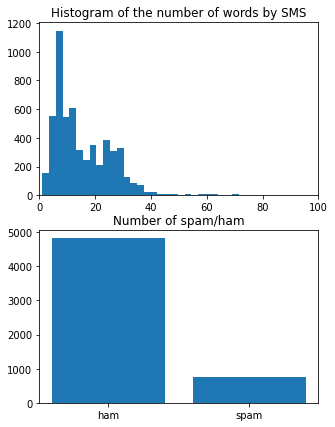

In [ ]:
number_of_words = df_sms['txt'].apply(lambda n: len(n.split()))

plt.figure(figsize=[5,7])
plt.subplot(2,1,1)
plt.hist(number_of_words, 70)
plt.xlim([0,100])
plt.title("Histogram of the number of words by SMS")
plt.subplot(2,1,2)
plt.bar(['ham','spam'], df_sms['cat'].value_counts()[['ham','spam']])
plt.title("Number of spam/ham")
plt.show()

## Enron

In [ ]:
df_enr = pd.DataFrame(columns=['cat', 'sub', 'txt'])
#df = df.append({'cat':'test_cat', 'sub':'test_sub', 'txt':'test_txt'}, ignore_index=True)

# Insert ham mails
dir_enron_ham = 'drive/MyDrive/NLP_datasets/enron/ham'
for filename in os.listdir(dir_enron_ham):
  with open(os.path.join(dir_enron_ham, filename), 'r', encoding="utf8", errors='ignore') as f:
    list_text = f.readlines()
    sub = list_text[0][9:].rstrip() # Parse the subject line
    txt = ' '.join(list_text[1:])
    df_enr = df_enr.append({'cat':'ham', 'sub':sub, 'txt':txt}, ignore_index=True)
    f.close()

# Insert spam mails
dir_enron_spam = 'drive/MyDrive/NLP_datasets/enron/spam'
for filename in os.listdir(dir_enron_spam):
  with open(os.path.join(dir_enron_spam, filename), 'r', encoding="utf8", errors='ignore') as f:
    try:
      list_text = f.readlines()
    except:
      print(filename)
    sub = list_text[0][9:].rstrip() # Parse the subject line
    txt = ' '.join(list_text[1:])
    df_enr = df_enr.append({'cat':'spam', 'sub':sub, 'txt':txt}, ignore_index=True)
    f.close()

df_enr.head()

,cat,sub,txt
0,ham,updated q & as for enron employees,updated questions and answers for enron employ...
1,ham,http : / / hrweb . enron . com / benefits / fo...,
2,ham,united way 2001 - building houston ' s future,"building houston ' s future , enron ' s 2001 u..."
3,ham,fw : tw rofr,"fyi , kim .\n - - - - - original message - - -..."
4,ham,br / tw window rock meeting scheduled for dec ...,"michelle ,\n we are looking forward to the pla..."


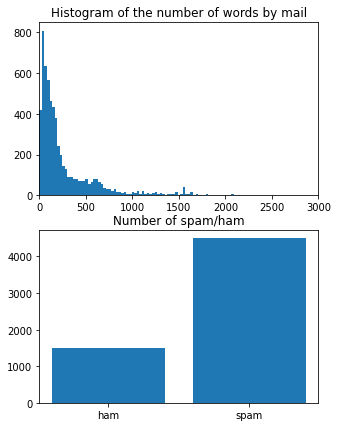

In [ ]:
number_of_words = df_enr['txt'].apply(lambda n: len(n.split()))

plt.figure(figsize=[5,7])
plt.subplot(2,1,1)
plt.hist(number_of_words, 200)
plt.xlim([0,3000])
plt.title("Histogram of the number of words by mail")
plt.subplot(2,1,2)
plt.bar(['ham','spam'], df_enr['cat'].value_counts()[['ham','spam']])
plt.title("Number of spam/ham")
plt.show()

## Spam Assassin

In [ ]:
df_ass = pd.DataFrame(columns=['cat', 'sub', 'txt'])
re_sub = re.compile('[Ss]ubject ?:')

# Insert ham mails

dirs_ham = ['easy_ham', 'easy_ham_2']
for dir_ext in dirs_ham:
  dir_spamassassin_ham = 'drive/MyDrive/NLP_datasets/spamassassin/'+dir_ext
  for filename in os.listdir(dir_spamassassin_ham):
    with open(os.path.join(dir_spamassassin_ham, filename), 'r', encoding="utf8", errors='ignore') as f:
      sub = ""
      txt = ""
      header = True
      for line in f:
        line = line.rstrip()
        if header:
          if line == "":
            header = False
          elif re_sub.match(line):
            sub = line[re_sub.match(line).span()[1]:] # Parse the subject line
        else:
          txt = txt + " " + line 
      txt = txt[1:]
      df_ass = df_ass.append({'cat':'ham', 'sub':sub, 'txt':txt}, ignore_index=True)
      f.close()

In [ ]:
# Insert spam mails
dirs_spam = ['spam', 'spam_2']
for dir_ext in dirs_spam:
  dir_spamassassin_spam = 'drive/MyDrive/NLP_datasets/spamassassin/'+dir_ext
  for filename in os.listdir(dir_spamassassin_spam):
    with open(os.path.join(dir_spamassassin_spam, filename), 'r', encoding="utf8", errors='ignore') as f:
      ub = ""
      txt = ""
      header = True
      for line in f:
        line = line.rstrip()
        if header:
          if line == "":
            header = False
          elif re_sub.match(line):
            sub = line[re_sub.match(line).span()[1]:] # Parse the subject line
        else:
          txt = txt + " " + line 
      txt = txt[1:]
      df_ass = df_ass.append({'cat':'spam', 'sub':sub, 'txt':txt}, ignore_index=True)
      f.close()

df_ass.head()

,cat,sub,txt
0,ham,[SAdev] [Bug 1008] SpamAssassin does not work...,http://www.hughes-family.org/bugzilla/show_bug...
1,ham,[SAdev] [Bug 839] mailbox corruption not fixe...,http://www.hughes-family.org/bugzilla/show_bug...
2,ham,[Spambayes] test sets?,">>>>> ""GvR"" == Guido van Rossum <guido@python..."
3,ham,Re: [Razor-users] Razor with sendmail,"""Bort, Paul"" <pbort@tmwsystems.com> wrote: >If..."
4,ham,Jeremy Zawodny who works at Yahoo Finance off...,URL: http://scriptingnews.userland.com/backiss...


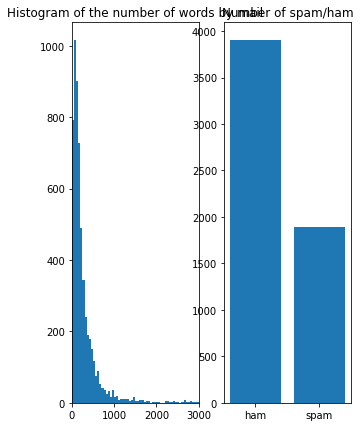

In [ ]:
number_of_words = df_ass['txt'].apply(lambda n: len(n.split()))

plt.figure(figsize=[5,7])
plt.subplot(1,2,1)
plt.hist(number_of_words, 300)
plt.xlim([0,3000])
plt.title("Histogram of the number of words by mail")
plt.subplot(1,2,2)
plt.bar(['ham','spam'], df_ass['cat'].value_counts()[['ham','spam']])
plt.title("Number of spam/ham")
plt.show()

## Preprocessing

In [ ]:
def preprocessing(df, bool_sub):
  # Lowercase
  txt_tkn = df['txt'].str.lower()
  if bool_sub: 
    sub_tkn = df['sub'].str.lower()

  # Tokenize
  new_stopwords = ['enron', 'com', 'http', 'nbsp']
  stop_words = set(stopwords.words('english') + new_stopwords)

  stemmer = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  tokenized_txt = []
  for str in txt_tkn:
    
    str = re.sub(r'<.+?>', '', str)
    str = re.sub(r'\S*https?:\S*', '', str)
    str = re.sub(r'\d+', '', str)
    str = re.sub(r'[^\w\s]', ' ', str)
    str = re.sub('email', 'mail', str)


    words = word_tokenize(str)
    # Remove stopwords
    words = [w for w in words if (not w in stop_words and len(w)>2)]
    # Stemmatization
    #words = [stemmer.stem(w) for w in words]
    # Lemmatization
    words = [lemmatizer.lemmatize(w,pos=wordnet.NOUN) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.VERB) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.ADJ) for w in words]
    #filtered_sentence = []
      
    #for w in word_tokens:
    #    if w not in stop_words:
    #        filtered_sentence.append(w)
    
    tokenized_txt.append(words)

  df['txt_tkn'] = tokenized_txt

  # sub
  tokenized_sub = []
  for str in sub_tkn:
    
    str = re.sub(r'<.+?>', '', str)
    str = re.sub(r'\S*https?:\S*', '', str)
    str = re.sub(r'\d+', '', str)
    str = re.sub(r'[^\w\s]', ' ', str)
    str = re.sub('email', 'mail', str)


    words = word_tokenize(str)
    # Remove stopwords
    words = [w for w in words if (not w in stop_words and len(w)>2)]
    # Stemmatization
    #words = [stemmer.stem(w) for w in words]
    # Lemmatization
    words = [lemmatizer.lemmatize(w,pos=wordnet.NOUN) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.VERB) for w in words]
    words = [lemmatizer.lemmatize(w,pos=wordnet.ADJ) for w in words]
    #filtered_sentence = []
      
    #for w in word_tokens:
    #    if w not in stop_words:
    #        filtered_sentence.append(w)
    
    tokenized_sub.append(words)

  df['sub_tkn'] = tokenized_sub

In [ ]:

preprocessing(df_ass, True)
df_ass

,cat,sub,txt,txt_tkn,sub_tkn
0,ham,[SAdev] [Bug 1008] SpamAssassin does not work...,http://www.hughes-family.org/bugzilla/show_bug...,"[jmason, org, change, remove, add, status, new...","[sadev, bug, spamassassin, work, glance]"
1,ham,[SAdev] [Bug 839] mailbox corruption not fixe...,http://www.hughes-family.org/bugzilla/show_bug...,"[additional, comment, alan, rdrop, try, yet, r...","[sadev, bug, mailbox, corruption, fix, procmail]"
2,ham,[Spambayes] test sets?,">>>>> ""GvR"" == Guido van Rossum <guido@python...","[gvr, guido, van, rossum, write, gvr, perhaps,...","[spambayes, test, set]"
3,ham,Re: [Razor-users] Razor with sendmail,"""Bort, Paul"" <pbort@tmwsystems.com> wrote: >If...","[bort, paul, write, sendmail, compile, milter,...","[razor, user, razor, sendmail]"
4,ham,Jeremy Zawodny who works at Yahoo Finance off...,URL: http://scriptingnews.userland.com/backiss...,"[url, date, mon, sep, gmt, jeremy, zawodny, wo...","[jeremy, zawodny, work, yahoo, finance, offer,..."
...,...,...,...,...,...
5791,spam,Turn Your PayPal account into a Non-Stop Cash...,I am sending you this message because we have ...,"[send, message, communicate, past, business, o...","[turn, paypal, account, non, stop, cash, machi..."
5792,spam,Stop creditors in their tracks 10891,** 5 FREE eBooks JUST FOR SIGNING UP. Sent via...,"[free, ebooks, sign, send, via, mail, within, ...","[stop, creditor, track]"
5793,spam,Online Approval for $5000 Now,<HTML><HEAD><TITLE>Free Card Search</TITLE> <M...,"[free, card, search, sincerely, new, offer, st...","[online, approval]"
5794,spam,hello,FROM=SEKO MOSHOOD MOBUTU Tel=234-1-776-2397 ...,"[seko, moshood, mobutu, tel, dear, friend, fir...",[hello]


In [ ]:
preprocessing(df_enr, True)
df_enr

,cat,sub,txt,txt_tkn,sub_tkn
0,ham,updated q & as for enron employees,updated questions and answers for enron employ...,"[update, question, answer, employee, post, hom...","[update, employee]"
1,ham,http : / / hrweb . enron . com / benefits / fo...,,[],"[hrweb, benefit, formp, asp]"
2,ham,united way 2001 - building houston ' s future,"building houston ' s future , enron ' s 2001 u...","[build, houston, future, unite, way, campaign,...","[unite, way, build, houston, future]"
3,ham,fw : tw rofr,"fyi , kim .\n - - - - - original message - - -...","[fyi, kim, original, message, harris, steven, ...",[rofr]
4,ham,br / tw window rock meeting scheduled for dec ...,"michelle ,\n we are looking forward to the pla...","[michelle, look, forward, plan, meet, discus, ...","[window, rock, meet, schedule, dec]"
...,...,...,...,...,...
6005,spam,miss you,"heytherecutie ,\n haven ' tseen youaround thes...","[heytherecutie, tseen, youaround, thesiteinawh...",[miss]
6006,spam,we understand your credit status,"hello ,\n you have been chosen to participate ...","[hello, choose, participate, invitation, event...","[understand, credit, status]"
6007,spam,free adult personals,biggest adult datlng dat 4 base with web c 4 m...,"[big, adult, datlng, dat, base, web, mscllck, ...","[free, adult, personal]"
6008,spam,ciallis softabs onlly $ 3 . 99 wkrk,""" ci - ialis softabs "" is better than pfizer v...","[ialis, softabs, good, pfizer, viiagrra, norma...","[ciallis, softabs, onlly, wkrk]"


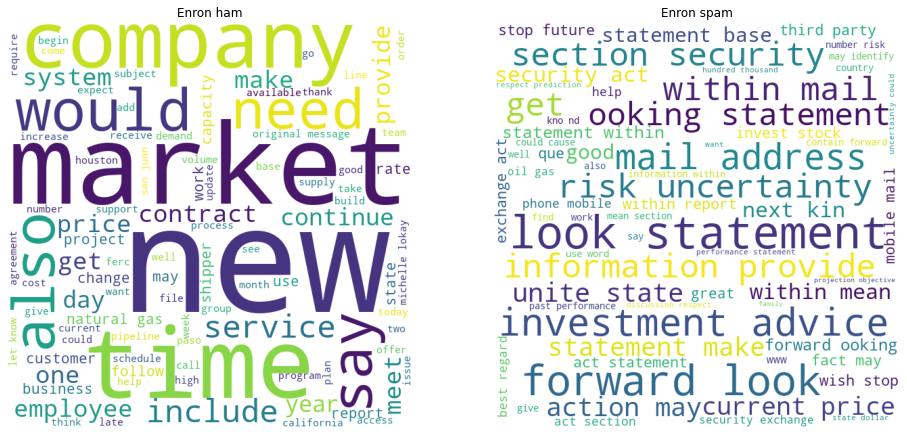

In [ ]:
input_txt_ham = " ".join([" ".join(list_of_words) for list_of_words in df_enr['txt_tkn'][df_enr['cat']=='ham']])
input_txt_spam = " ".join([" ".join(list_of_words) for list_of_words in df_enr['txt_tkn'][df_enr['cat']=='spam']])
#input_txt = " ".join(df_ass['txt'])

wordcloud_ham = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_ham)

wordcloud_spam = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_spam)
 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_ham)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Enron ham')

plt.subplot(1,2,2)
plt.imshow(wordcloud_spam)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Enron spam')
 
plt.show()

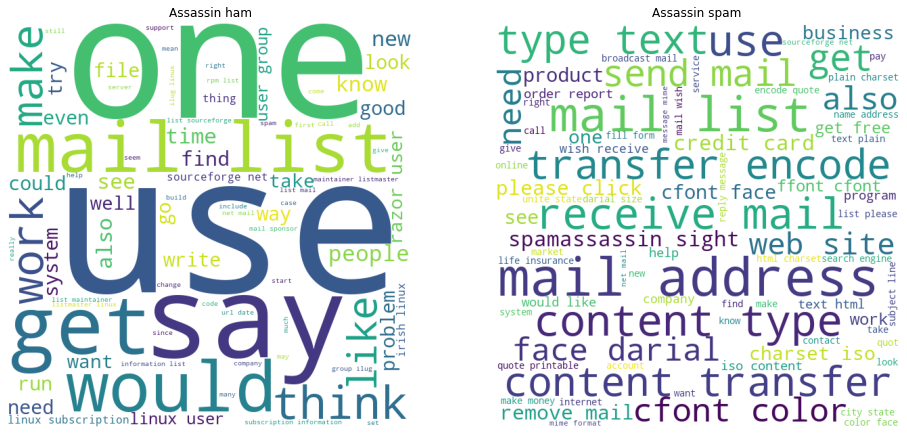

In [ ]:
input_txt_ham = " ".join([" ".join(list_of_words) for list_of_words in df_ass['txt_tkn'][df_ass['cat']=='ham']])
input_txt_spam = " ".join([" ".join(list_of_words) for list_of_words in df_ass['txt_tkn'][df_ass['cat']=='spam']])
#input_txt = " ".join(df_ass['txt'])

wordcloud_ham = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_ham)

wordcloud_spam = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(input_txt_spam)
 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_ham)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Assassin ham')

plt.subplot(1,2,2)
plt.imshow(wordcloud_spam)
plt.axis("off")
#plt.tight_layout(pad = 0)
plt.title('Assassin spam')
 
plt.show()

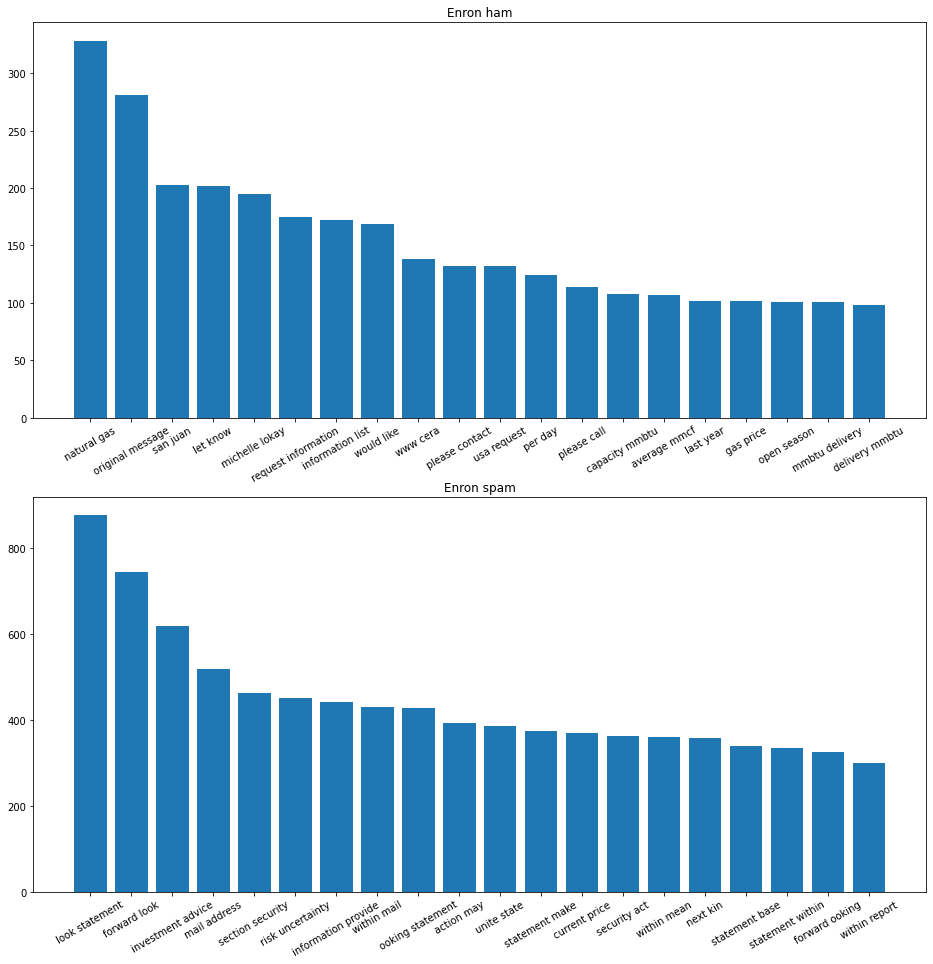

In [ ]:
words_ham_ = df_enr['txt_tkn'][df_enr['cat']=='ham']
words_spam_ = df_enr['txt_tkn'][df_enr['cat']=='spam']

words_ham = [wrd for line in words_ham_.tolist() for wrd in line]
words_spam = [wrd for line in words_spam_.tolist() for wrd in line]

bigrams_ham = nltk.bigrams(words_ham)
freq_ham = nltk.FreqDist(bigrams_ham).most_common(20)
freq_ham = pd.Series(dict(freq_ham))

bigrams_spam = nltk.bigrams(words_spam)
freq_spam = nltk.FreqDist(bigrams_spam).most_common(20)
freq_spam = pd.Series(dict(freq_spam))

plt.figure(figsize = (16, 16))

plt.subplot(2,1,1)

y = freq_ham.values
x = [ b[0]+' '+b[1] for b in freq_ham.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Enron ham')

plt.subplot(2,1,2)

y = freq_spam.values
x = [ b[0]+' '+b[1] for b in freq_spam.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Enron spam')
 
plt.show()

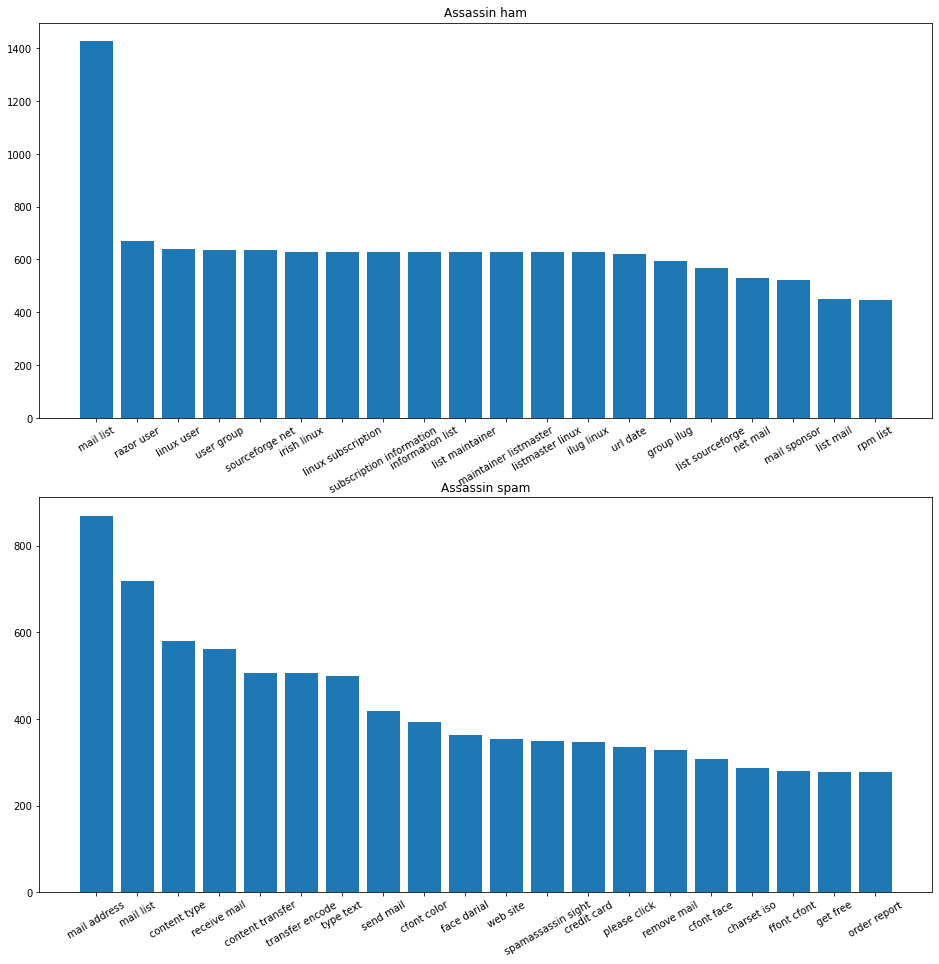

In [ ]:
words_ham_ = df_ass['txt_tkn'][df_ass['cat']=='ham']
words_spam_ = df_ass['txt_tkn'][df_ass['cat']=='spam']

words_ham = [wrd for line in words_ham_.tolist() for wrd in line]
words_spam = [wrd for line in words_spam_.tolist() for wrd in line]

bigrams_ham = nltk.bigrams(words_ham)
freq_ham = nltk.FreqDist(bigrams_ham).most_common(20)
freq_ham = pd.Series(dict(freq_ham))

bigrams_spam = nltk.bigrams(words_spam)
freq_spam = nltk.FreqDist(bigrams_spam).most_common(20)
freq_spam = pd.Series(dict(freq_spam))

plt.figure(figsize = (16, 16))

plt.subplot(2,1,1)

y = freq_ham.values
x = [ b[0]+' '+b[1] for b in freq_ham.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Assassin ham')

plt.subplot(2,1,2)

y = freq_spam.values
x = [ b[0]+' '+b[1] for b in freq_spam.index]

plt.bar(x,y)
plt.xticks(rotation=30);
plt.title('Assassin spam')
 
plt.show()

## Feature Extraction 

## Classification

In [ ]:
(x_train,x_test,y_train,y_test)=train_test_split(df_enr['txt_tkn'],df_enr['cat'],test_size=0.2)
#x_train.head()
indexes_of_x_train = x_train.index
indexes_of_x_test = x_test.index

In [ ]:
# create the transform
vectorizer = CountVectorizer()

# tokenize and build vocab
x_train_features = vectorizer.fit_transform(x_train.apply(lambda x: " ".join(x) ))
x_test_features = vectorizer.transform(x_test.apply(lambda x: " ".join(x) ))

In [ ]:
vectorizer.vocabulary_

{'please': 34261,
 'inform': 22839,
 'mini': 28871,
 'bus': 6381,
 'reserve': 37693,
 'convenience': 9955,
 'transport': 44751,
 'sanibel': 39053,
 'harbour': 20305,
 'resort': 37744,
 'airport': 1190,
 'wednesday': 47781,
 'afternoon': 976,
 'upon': 46037,
 'arrival': 2881,
 'fort': 17804,
 'myers': 29897,
 'greet': 19688,
 'pt': 35780,
 'transportation': 44752,
 'service': 39923,
 'submit': 42341,
 'steve': 41989,
 'name': 30001,
 'point': 34426,
 'contact': 9790,
 'safe': 38884,
 'pleasant': 34259,
 'flight': 17449,
 'adr': 738,
 'jean': 24088,
 'would': 48525,
 'group': 19787,
 'responsibility': 37776,
 'purchase': 35942,
 'instal': 23107,
 'need': 30267,
 'software': 41124,
 'palm': 32701,
 'pilot': 34016,
 'new': 30427,
 'staff': 41768,
 'member': 28366,
 'michelle': 28668,
 'lokay': 26800,
 'forward': 17831,
 'necessary': 30245,
 'form': 17756,
 'thank': 43702,
 'advance': 779,
 'unsubscribe': 45944,
 'best': 4756,
 'thing': 43883,
 'life': 26292,
 'really': 36833,
 'free': 1800

### Naive Bayes classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train_features.toarray() ,y_train)

# Output of the score is the accuracy of the prediction
# Accuracy: 0.990
print("Training accuracy: ", clf.score(x_train_features.toarray(),y_train))
# Accuracy: 0.941
print("Testing accuracy: ", clf.score(x_test_features.toarray(),y_test))

Training accuracy:  0.9908485856905158
Testing accuracy:  0.9359400998336106


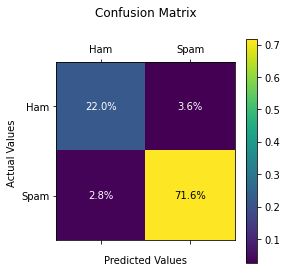

In [ ]:
y_pred = clf.predict(x_test_features.toarray())

conf_mat = confusion_matrix(y_test, y_pred) / len(y_test)

plt.matshow(conf_mat)

plt.title('Confusion Matrix\n\n')
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values ')

plt.colorbar()

plt.xticks([0,1],['Ham','Spam'])
plt.yticks([0,1], ['Ham','Spam'])

plt.text(0, 0, '{:0.1f}%'.format(conf_mat[0][0]*100), ha='center', va='center', c='w')
plt.text(0, 1, '{:0.1f}%'.format(conf_mat[0][1]*100), ha='center', va='center', c='w')
plt.text(1, 0, '{:0.1f}%'.format(conf_mat[1][0]*100), ha='center', va='center', c='w')
plt.text(1, 1, '{:0.1f}%'.format(conf_mat[1][1]*100), ha='center', va='center')

plt.show()


## DL classifier

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(df_enr['txt'], df_enr['cat'], test_size=0.2)
X_train =[' '.join(list_words) for list_words in x_train]
X_test =[' '.join(list_words) for list_words in x_test]

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok = pad_sequences(X_train_tok, truncating = 'post', padding='post', maxlen=50)
X_test_tok = tokenizer.texts_to_sequences(X_test)
X_test_tok = pad_sequences(X_test_tok, truncating = 'post', padding='post', maxlen=50)

y_train_tok = [[1,0] if word == 'ham' else [0,1] for word in y_train]
y_train_tok = np.asarray(y_train_tok)

In [ ]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,16,input_length=50),
tf.keras.layers.Dropout(.0),
tf.keras.layers.LSTM(20, return_sequences=True),
tf.keras.layers.Dropout(.0),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dropout(.0),
tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(
     loss='categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 dropout_1 (Dropout)         (None, 50, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [ ]:
model.fit(
     X_train_tok, y_train_tok,
     epochs=5, validation_split = 0.2)

Epoch 1/5
121/121 [==============================] - 13s 69ms/step - loss: 0.3684 - accuracy: 0.8396 - val_loss: 0.1032 - val_accuracy: 0.9678
Epoch 2/5
121/121 [==============================] - 7s 61ms/step - loss: 0.0552 - accuracy: 0.9860 - val_loss: 0.1701 - val_accuracy: 0.9459
Epoch 3/5
121/121 [==============================] - 7s 61ms/step - loss: 0.0241 - accuracy: 0.9930 - val_loss: 0.1228 - val_accuracy: 0.9626
Epoch 4/5
121/121 [==============================] - 7s 61ms/step - loss: 0.0150 - accuracy: 0.9961 - val_loss: 0.1110 - val_accuracy: 0.9719
Epoch 5/5
121/121 [==============================] - 11s 94ms/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 0.0889 - val_accuracy: 0.9782


In [ ]:
out = np.reshape(X_train_tok[0], (1,50))
print(model.predict(out))
last_lay_input = None
val = []
for lay in list(map(lambda x: x.name, model.layers)):
  if(last_lay_input is None ):
    last_lay_input = model.input
  intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
  out = intermediate_output(out)
  #print(tf.reshape(out, [-1]))
  if(lay[0:7] != 'dropout' ):
    print(lay)
    val.append(tf.reshape(out, [-1]))
  last_lay_input = model.get_layer(lay).output
print(out)

1/1 [==============================] - 1s 925ms/step
[[0.9957969  0.00420312]]
embedding
lstm
lstm_1
dense
tf.Tensor([[0.9957969  0.00420312]], shape=(1, 2), dtype=float32)


38/38 [==============================] - 0s 11ms/step


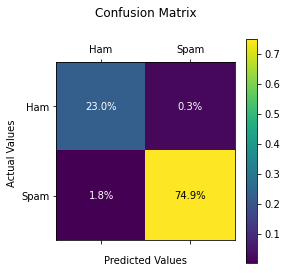

In [ ]:
y_pred = model.predict(X_test_tok)

y_pred_trim = [['ham','spam'][np.argmax(classes)] for classes in y_pred]

conf_mat = confusion_matrix(y_test, y_pred_trim) / len(y_test)

plt.matshow(conf_mat)

plt.title('Confusion Matrix\n\n')
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values ')

plt.colorbar()

plt.xticks([0,1],['Ham','Spam'])
plt.yticks([0,1], ['Ham','Spam'])

plt.text(0, 0, '{:0.1f}%'.format(conf_mat[0][0]*100), ha='center', va='center', c='w')
plt.text(0, 1, '{:0.1f}%'.format(conf_mat[0][1]*100), ha='center', va='center', c='w')
plt.text(1, 0, '{:0.1f}%'.format(conf_mat[1][0]*100), ha='center', va='center', c='w')
plt.text(1, 1, '{:0.1f}%'.format(conf_mat[1][1]*100), ha='center', va='center')

plt.show()


In [ ]:
w_indexs = []
for v in val:
  w_indexs.append(len(v))
w_indexs = w_indexs[0:-1]
print(w_indexs)

[800, 1000, 20]


In [ ]:
n_of_points = X_train_tok.shape[0]
X = np.zeros((n_of_points,1820))
for i in range(n_of_points):
  if(i%1000 == 999):
    print(i+1)
  val = []
  out = np.reshape(X_train_tok[i], (1,50))
  last_lay_input = None
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' ):
      val.append(tf.reshape(out, [-1]))
    last_lay_input = model.get_layer(lay).output
  X[i,:] = np.concatenate(val[0:-1])

1000
2000
3000
4000


## XAI

In [ ]:
y_lr = [ 1 if word == 'ham' else 0 for word in y_train]
y_lr_test = [ 1 if word == 'ham' else 0 for word in y_test]

#X_test_l = X_test.tolist()
X_test_l = X_test

In [ ]:
clf = LogisticRegression(penalty='l2').fit(X, y_lr)
ranking = np.flip(np.argsort(np.absolute(clf.coef_)))

In [ ]:
perc = 0.3
N = sum(w_indexs)
bin_opt = np.zeros(N)
idx = ranking[0][0:math.floor(N*perc)]
for id in idx:
  bin_opt[id] = 1

n_of_points = X_test_tok.shape[0]
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)
Acc = 0

for i in range(n_of_points):
  if(i%500 == 499):
    print(i+1)
  out = np.reshape(X_test_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      shape = out.shape
      out = tf.reshape(out, [-1]) * bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
      out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output
  

  if((out[0][0] > 0.5 and y_lr_test[i]==1) or (out[0][0] < 0.5 and y_lr_test[i]==0)):
    Acc +=1

print(Acc/n_of_points)

500
1000
0.961730449251248


In [ ]:
bin_opt = np.zeros(N)
idx = ranking[0][math.floor(N*(1-perc)):-1]
for id in idx:
  bin_opt[id] = 1

n_of_points = X_test_tok.shape[0]
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)
Acc = 0

for i in range(n_of_points):
  if(i%500 == 499):
    print(i+1)
  out = np.reshape(X_test_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      shape = out.shape
      out = tf.reshape(out, [-1]) * bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
      out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output
  

  if((out[0][0] > 0.5 and y_lr_test[i]==1) or (out[0][0] < 0.5 and y_lr_test[i]==0)):
    Acc +=1

print(Acc/n_of_points)

500
1000
0.2703826955074875


### Test for msg 1

In [ ]:
X_test_l =[' '.join(list_words) for list_words in x_test]

In [ ]:
word = X_test_l[1].split(" ")
words = []
for i in range(len(word)):
  w = [x for j,x in enumerate(word) if j!=i]
  words.append(' '.join(w))

In [ ]:
min(x_test.index)
df_enr['txt'][0]
X_train[0:3]


['please inform mini bus reserve convenience transport sanibel harbour resort airport wednesday afternoon upon arrival fort myers airport greet pt transportation service submit steve name point contact safe pleasant flight adr',
 'jean would group responsibility purchase instal need software palm pilot new staff member michelle lokay please forward necessary form purchase thank advance adr',
 'unsubscribe']

In [ ]:
#1816

X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

NN = 1816

n_of_points = len(words)
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

vals = []

for i in range(n_of_points):
  if(i%10 == 9):
    print(i+1)
  out = np.reshape(X_word_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
        shape = out.shape
        out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
        vals.append(out[NN-cum_sum[l_C]].numpy())
        out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output


for i in range(len(words)):
  print(word[i] , " ", (vals[i]-np.mean(vals)) * 100 )

10
20
30
40
50
60
new   -0.3145575523376465
qem   0.03647208213806152
software   0.21107196807861328
www   -0.19228458404541016
allsoftbest   0.0326991081237793
info   0.2634406089782715
system   0.05396604537963867
work   -0.2376854419708252
professional   0.08206367492675781
hinge   0.032401084899902344
system   0.042510032653808594
work   -0.21026134490966797
professional   0.06128549575805664
cocky   0.02372264862060547
system   0.03235936164855957
work   -0.18627643585205078
professional   0.044918060302734375
bunsen   -0.03421306610107422
system   0.02231001853942871
work   -0.16856789588928223
professional   0.030338764190673828
timetable   -0.11413097381591797
system   0.011831521987915039
work   -0.15631318092346191
professional   0.015050172805786133
overlook   -0.004088878631591797
system   0.008803606033325195
work   -0.1419663429260254
professional   0.007146596908569336
morton   -0.01043081283569336
system   0.007867813110351562
work   -0.12989044189453125
professional   

In [ ]:
r = []
g = []
b = []
out_str = ''
norm = max(np.abs(vals-np.mean(vals)))
for i in range(len(words)):
  a = (vals[i]-np.mean(vals)) / norm
  r = int(255 + min(0, -255*a))
  g = int(255 + min(0, 255*a))
  b = int(255*(1-abs(a)))
  out_str = out_str + f'\x1b[1;48;2;{r};{g};{b}m' + word[i] + '\x1b[0m '

print(out_str)

new qem software www allsoftbest info system work professional hinge system work professional cocky system work professional bunsen system work professional timetable system work professional overlook system work professional morton system work professional unchanging system work professional terrier system work professional waitress system work professional tranquilly system work professional bridle system work professional locate system work professional regulate www allsoftbest info 


In [ ]:
idx_mail = 1 ###
n_max_count_char = 100 ###
idx_tok = 0
lemmatizer = WordNetLemmatizer()
out_str = ''
count_char = 0
norm = max(np.abs(vals-np.mean(vals)))
vals_w = (vals-np.mean(vals)) / norm
str_vals = ''

#del(str) # avoid bugs

#for w in df_enr['txt'][idx_mail].split():
for w in df_enr['txt'][x_test.index[idx_mail]].split():
  if (idx_tok < len(word)) and (word[idx_tok] in {lemmatizer.lemmatize(w,pos=wordnet.NOUN) , lemmatizer.lemmatize(w,pos=wordnet.VERB), lemmatizer.lemmatize(w,pos=wordnet.ADJ)} or (w == 'email' and word[idx_tok]=='mail')):
    #a = (vals[idx_tok]-np.mean(vals)) / norm
    a = vals_w[idx_tok]
    r = int(255 + min(0, -255*a))
    g = int(255 + min(0, 255*a))
    b = int(255*(1-abs(a)))
    out_str = out_str + f'\x1b[1;48;2;{r};{g};{b}m' + w + '\x1b[0m '
    idx_tok += 1

    str_vals += str(round(a,1)) + ' '*(len(w)-2 - 1*(a<0)) 
  else:
    out_str = out_str + w + ' '
    str_vals += ' '*(len(w)+1)
  
  count_char += len(w) + 1
  if count_char > n_max_count_char:
    out_str = out_str + '\n' + str_vals + '\n\n'
    str_vals = ''
    count_char = 0

out_str = out_str + '\n' + str_vals 
print(out_str)

new qem software http : / / www . allsoftbest . info / system works 2004 professional - 40 hinged system 
-1.00.1 0.7                 -0.6  0.1           0.8    0.2    -0.8       0.3               0.1    0.1    

works 2004 professional - 40 cocky system works 2004 professional - 40 bunsen system works 2004 professional 
-0.7       0.2               0.1   0.1    -0.6       0.1               -0.1   0.1    -0.5       0.1          

- 40 timetable system works 2004 professional - 40 overlooks system works 2004 professional - 40 morton 
     -0.4      0.0    -0.5       0.0               -0.0      0.0    -0.5       0.0               -0.0   

system works 2004 professional - 40 unchanging system works 2004 professional - 40 terriers system works 
0.0    -0.4       0.0               -0.1       0.0    -0.4       -0.0              -0.1     0.0    -0.3  

2004 professional - 40 waitress system works 2004 professional - 40 tranquilly system works 2004 professional 
     -0.0              -0.1    

### Test for msg 3

In [ ]:
word = X_test_l[3].split(" ")
words = []
for i in range(len(word)):
  w = [x for j,x in enumerate(word) if j!=i]
  words.append(' '.join(w))

In [ ]:
#1816

X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

NN = 1816

n_of_points = len(words)
print(n_of_points)
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

vals = []

for i in range(n_of_points):
  if(i%10 == 9):
    print(i+1)
  out = np.reshape(X_word_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
        shape = out.shape
        out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
        vals.append(out[NN-cum_sum[l_C]].numpy())
        out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output

for i in range(len(words)):
  print(word[i] , " ", (vals[i]-np.mean(vals)) * 100 )

38
10
20
30
switchboard   0.0821232795715332
viet   0.0821232795715332
stampede   0.0821232795715332
initialization   0.0821232795715332
whip   0.0821232795715332
leonardo   -0.0010371208190917969
landscape   0.03439784049987793
concur   -0.157928466796875
accomplice   0.06427168846130371
percent   -0.1268446445465088
peer   -0.14333724975585938
humidity   0.04426836967468262
wad   -0.0006437301635742188
big   -0.07228851318359375
collect   -0.07742643356323242
antigen   0.03132224082946777
reticulate   0.03132224082946777
binary   0.03132224082946777
folsom   0.03132224082946777
decay   0.03132224082946777
voltage   -0.05320906639099121
january   -0.12146830558776855
medic   0.01965165138244629
paterson   0.01965165138244629
inside   -0.006783008575439453
impedance   0.01830458641052246
hooker   0.01830458641052246
empower   -0.06286501884460449
therewith   0.015330314636230469
hatfield   0.015330314636230469
hold   -0.013631582260131836
unwanted   -0.04979968070983887
artificially   

In [ ]:
r = []
g = []
b = []
str = ''
norm = max(np.abs(vals-np.mean(vals)))
for i in range(len(words)):
  a = (vals[i]-np.mean(vals)) / norm
  r = int(255 + min(0, -255*a))
  g = int(255 + min(0, 255*a))
  b = int(255*(1-abs(a)))
  str = str + f'\x1b[1;48;2;{r};{g};{b}m' + word[i] + '\x1b[0m '

print(str)

switchboard viet stampede initialization whip leonardo landscape concur accomplice percent peer humidity wad big collect antigen reticulate binary folsom decay voltage january medic paterson inside impedance hooker empower therewith hatfield hold unwanted artificially hitchhiker nondecreasing bequeath astutely hangman 


### Test for msg 11

In [ ]:
word = X_test_l[11].split(" ")
words = []
for i in range(len(word)):
  w = [x for j,x in enumerate(word) if j!=i]
  words.append(' '.join(w))

In [ ]:
#1816

X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

NN = 1816

n_of_points = len(words)
print(n_of_points)
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

vals = []

for i in range(n_of_points):
  if(i%10 == 9):
    print(i+1)
  out = np.reshape(X_word_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
        shape = out.shape
        out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
        vals.append(out[NN-cum_sum[l_C]].numpy())
        out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output

for i in range(len(words)):
  print(word[i] , " ", (vals[i]-np.mean(vals)) * 100 )

3
buenos   2.059084177017212
tardes   1.5026718378067017
adios   -3.561753034591675


In [ ]:
a = -0.05;
r = int(255 + min(0, 255*a))
g = int(255 + min(0, -255*a))
b = int(255*(1-abs(a)))
str = '\x1b[28;2;0;0;0m' + f'\x1b[48;2;{r};{g};{b}m' +'Hello'+ '\x1b[' + ' ' +'\x1b[28;2;0;0;0m' + '\x1b[48;2;0;255;50m' + 'world' '\x1b[0m'

#print('\x1b[28;2;0;0;0m' + '\x1b[48;2;255;230;200m' +'Hello'+ '\x1b[' + ' ' +'\x1b[28;2;0;0;0m' + '\x1b[48;2;0;255;50m' + 'world' '\x1b[0m')
print(str)

Hello[ world


In [ ]:
#words = ['aze', 'rty', 'uio', 'p']
#idx = [-0.5, 0.9, 0.33, -0.65]

r = []
g = []
b = []
str = ''
norm = max(np.abs(vals-np.mean(vals)))
for i in range(len(words)):
  a = (vals[i]-np.mean(vals)) / norm
  r = int(255 + min(0, -255*a))
  g = int(255 + min(0, 255*a))
  b = int(255*(1-abs(a)))
  str = str + f'\x1b[1;48;2;{r};{g};{b}m' + word[i] + '\x1b[0m '

print(str)

buenos tardes adios 


## I test things

In [ ]:
word = X_test_l[1].split(" ")
words = []
for i in range(len(word)):
  w = [x for j,x in enumerate(word) if j!=i]
  words.append(' '.join(w))

In [ ]:
#1816

X_word_tok = tokenizer.texts_to_sequences(pd.Series(words))
X_word_tok = pad_sequences(X_word_tok, truncating = 'post', padding='post', maxlen=50)

NN = 1816

n_of_points = len(words)
print(n_of_points)
cum_sum = np.append(np.append(np.zeros(1),np.cumsum(w_indexs)),np.ones(1)*(np.sum(w_indexs)+2)).astype(int)

vals = []

for i in range(n_of_points):
  if(i%10 == 9):
    print(i+1)
  out = np.reshape(X_word_tok[i], (1,50))
  last_lay_input = None
  l_C = 0
  for lay in list(map(lambda x: x.name, model.layers)):
    if(last_lay_input is None ):
      last_lay_input = model.input
    intermediate_output = tf.keras.Model(last_lay_input, model.get_layer(lay).output)
    out = intermediate_output(out)
    if(lay[0:7] != 'dropout' and l_C < 3):
      if(cum_sum[l_C] <= NN and cum_sum[l_C+1] >= NN):
        shape = out.shape
        out = tf.reshape(out, [-1]) #* bin_opt[cum_sum[l_C]:cum_sum[l_C+1]]
        vals.append(out[NN-cum_sum[l_C]].numpy())
        out = tf.reshape(out, shape)
      l_C +=1
    last_lay_input = model.get_layer(lay).output

# List of the N most "spammish" words
M = 30
idx = pd.Series(vals).nlargest(20)

idx_max_M = idx.index.values.tolist()
words_spam = list(dict.fromkeys([word[l] for l in idx_max_M]))
M = len(words_spam)
#vals_spam = word[idx_max_M]

61
10
20
30
40
50
60


In [ ]:
# Create datasets for every word
N = 100
N_first_mails = df_enr['txt'][0:N]
#new_col = []
data = {'txt':N_first_mails}

for i in range(M):
  y_i = []
  for j in range(N):
    y_i.append(int(words_spam[i] in N_first_mails[j].split()))
  #new_col.append(y_i)
  data[f'{i}'] = y_i

df_N_M = pd.DataFrame(data)

In [ ]:
# Train N models
# Suppose weights the frozen weights of each neuron, and weight_spam the weights in the first problem
X = df_N_M['txt']

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(X)

X_tok = tokenizer.texts_to_sequences(X)
X_tok = pad_sequences(X_tok, truncating = 'post', padding='post', maxlen=50)

weights_occ = []

for i in range(M):
  y = df_N_M[f'{i}']

  y_tok = [[1,0] if res == 1 else [0,1] for res in y]
  y_tok = np.asarray(y_tok)

  m = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000,16,input_length=50),
  tf.keras.layers.Dropout(.0),
  tf.keras.layers.LSTM(20, return_sequences=True),
  tf.keras.layers.Dropout(.0),
  tf.keras.layers.LSTM(20),
  tf.keras.layers.Dropout(.0),
  tf.keras.layers.Dense(2, activation='softmax')
  ])
  m.verbose = False
  m.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  m.fit(
     X_tok, y_tok,
     epochs=5, validation_split = 0.2)
  
  wghts_lay = []
  for layer in m.layers:
    if(layer.get_weights()): #Dropout has no weights
      wghts_lay.append(layer.get_weights()[0].reshape((-1,)))
      # print(layer.name, "LEN:", len(layer.get_weights()))
      # wth_lay = []
      # for i in range(len(layer.get_weights())):
      #   #print(layer.get_weights()[i].shape)
      #   wth_lay.append(layer.get_weights()[i])
      # whts.append(wth_lay)
  weights_occ.append(wghts_lay)


Epoch 1/5
3/3 [==============================] - 6s 586ms/step - loss: 0.6863 - accuracy: 0.8375 - val_loss: 0.6681 - val_accuracy: 1.0000
Epoch 2/5
3/3 [==============================] - 0s 62ms/step - loss: 0.6591 - accuracy: 0.9500 - val_loss: 0.6386 - val_accuracy: 1.0000
Epoch 3/5
3/3 [==============================] - 0s 66ms/step - loss: 0.6276 - accuracy: 0.9500 - val_loss: 0.6011 - val_accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 0s 62ms/step - loss: 0.5868 - accuracy: 0.9500 - val_loss: 0.5509 - val_accuracy: 1.0000
Epoch 5/5
3/3 [==============================] - 0s 61ms/step - loss: 0.5324 - accuracy: 0.9500 - val_loss: 0.4803 - val_accuracy: 1.0000
Epoch 1/5
3/3 [==============================] - 6s 601ms/step - loss: 0.6911 - accuracy: 0.6125 - val_loss: 0.6731 - val_accuracy: 1.0000
Epoch 2/5
3/3 [==============================] - 0s 60ms/step - loss: 0.6653 - accuracy: 1.0000 - val_loss: 0.6488 - val_accuracy: 1.0000
Epoch 3/5
3/3 [=================

In [ ]:
weights_spam = []
for layer in model.layers:
  if(layer.get_weights()): #Dropout has no weights
    #print(layer.name, "LEN:", len(layer.get_weights()))
    # wth_lay = []
    # for i in range(len(layer.get_weights())):
    #   #print(layer.get_weights()[i].shape)
    #   wth_lay.append(layer.get_weights()[i])
    weights_spam.append(layer.get_weights()[0].reshape((-1,)))

#weights_spam = np.reshape(weights_spam,(1,-1))

In [ ]:
# Scalar product for ML models, returns <w1,w2>/||w2||
def scalprod(w1,w2):
  scal = 0
  norm = 0
  for layer in range(len(w1)):
    scal += np.dot(w1[layer],w2[layer])
    norm += np.dot(w2[layer],w2[layer])

  scal = scal/np.sqrt(norm)

  res = w1
  for layer in range(len(w1)):
    res[layer] -= scal*w2[layer]/np.sqrt(norm)

  return (scal,res)

In [ ]:
coef = []
res_wgth = weights_spam

for i in range(M):
  (scal,res) = scalprod(res_wgth,weights_occ[i])
  coef.append(scal)
  res_wgth = res

In [ ]:
print(coef)
print(words_spam)

[0.013291104210939316, 0.03657397808378287, -0.055751238509566016, -0.18290278072261054, -0.13570788820564977, 0.06418056917998471, 0.06987034004634099, 0.06401204966177086, 0.09565130020013238, -0.18382741815012899]
['info', 'software', 'system', 'work', 'professional', 'locate', 'regulate', 'www', 'allsoftbest', 'qem']


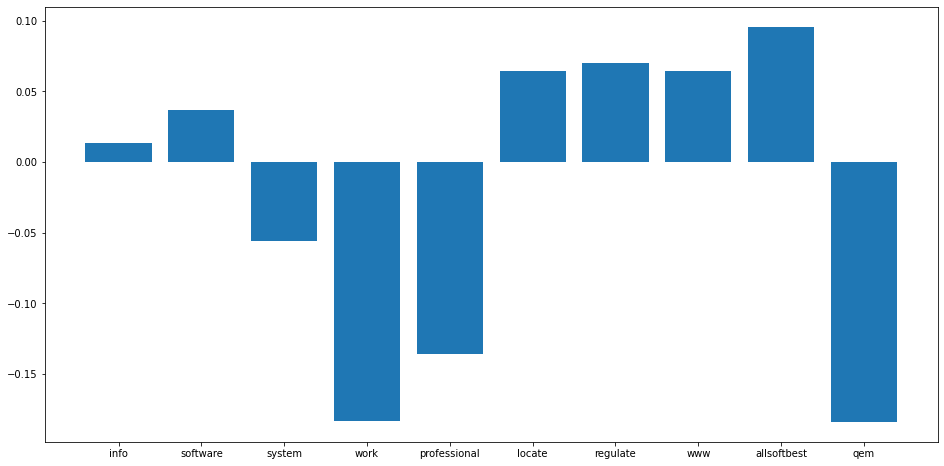

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(words_spam,coef)
plt.show()